In [121]:
import pandas as pd
import edge_blob
import ai_service


In [122]:
import datetime
import json

t = datetime.datetime(2024, 10, 7, 14, 15, 0)
raw_data = json.dumps({
            "time": ai_service.datetime_to_list(t),
            "filePath": "Curated Data/yngetl/" + (t - datetime.timedelta(seconds=15)).strftime('%Y/%m/%d/%H/%M/%S/'),
            # "filePath": (t - datetime.timedelta(seconds=15)).strftime('%Y/%m/%d/%H/%M/%S/'),
            "fileLastTs": t.strftime('%Y-%m-%d %H:%M:%S'),
            "connection": 'Azure'

        })
output_json = ai_service.run(raw_data)

35.21590909090909
35.21590909090909


In [123]:
import numpy as np
predicted_weight = np.round(json.loads(output_json)['WeightPredictionBeforeChange'], 4)

In [124]:
import io

t_actual = t + datetime.timedelta(minutes=2)
Blob_Target = edge_blob.AzureBlobStorage(connection_string=edge_blob.BlobConfig.target_conn_str)

blob_data = Blob_Target.download_blob(edge_blob.BlobConfig.target_container_name, "Curated Data/yngetl/" + t_actual.strftime('%Y/%m/%d/%H/%M/%S/') + 'merge.csv')
df_merge = pd.read_csv(io.BytesIO(blob_data))

blob_data = Blob_Target.download_blob(edge_blob.BlobConfig.target_container_name, "Curated Data/yngetl/" + t_actual.strftime('%Y/%m/%d/%H/%M/%S/') + 'curated_parm.csv')
df_ot = pd.read_csv(io.BytesIO(blob_data))

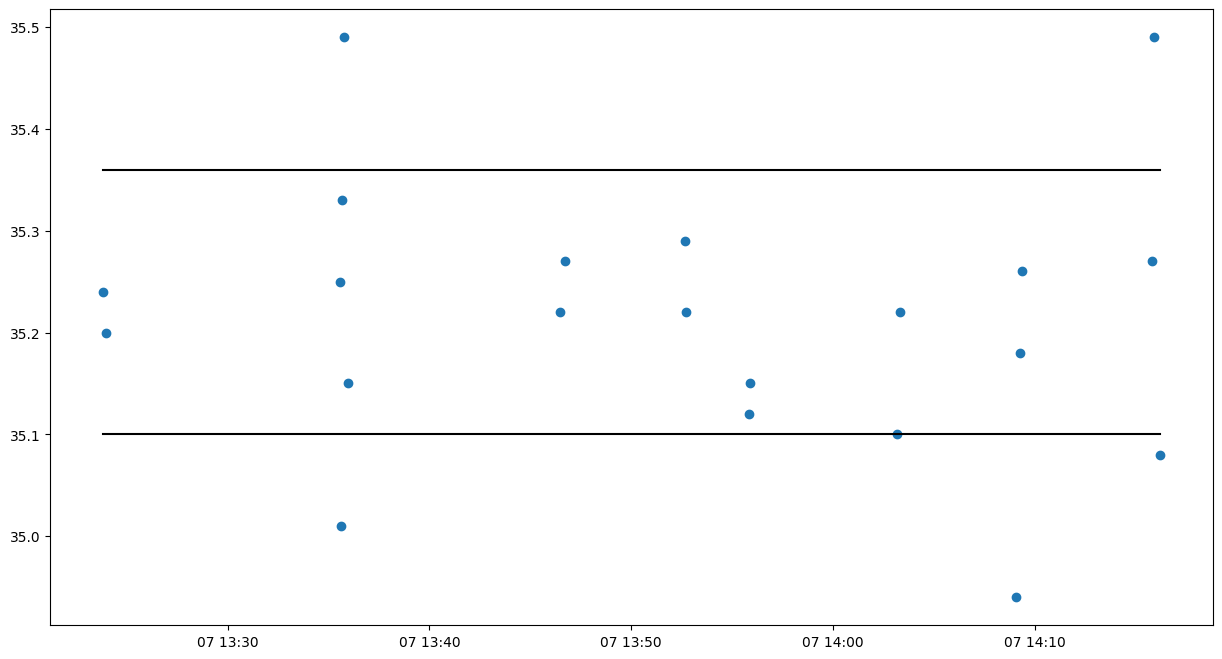

In [125]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 8))
df_merge['DataTime'] = [pd.Timestamp(x) for x in df_merge['DataTime']]
plt.scatter(df_merge['DataTime'], df_merge['Weight'])
plt.plot([np.min(df_merge['DataTime']), np.max(df_merge['DataTime'])], [35.36, 35.36], 'black')
plt.plot([np.min(df_merge['DataTime']), np.max(df_merge['DataTime'])], [35.1, 35.1], 'black')

In [126]:
t_actual.strftime('%Y/%m/%d/%H/%M/%S/')


'2024/10/07/14/17/00/'

In [127]:
name_mapping = {
        'DataTime': 'Date',
        'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap3rdSizing.rActualPosition_inches': 'Gap3',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap3rdSizing.rActualPosition_inches': 'Prev_Gap3',
        'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap2ndSizing.rActualPosition_inches': 'Gap2',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap2ndSizing.rActualPosition_inches': 'Prev_Gap2',
        'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap1stSizing.rActualPosition_inches': 'Gap1',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap1stSizing.rActualPosition_inches': 'Prev_Gap1',
        'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_GapFinalSizing.rActualPosition_inches': 'GapFS',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_GapFinalSizing.rActualPosition_inches': 'Prev_GapFS',
        'CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rSetpoint_Ratio': 'CrossScore',
        'CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rActualVelocityRPM': 'ActualCrossScore',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rSetpoint_Ratio': 'Prev_CrossScore',
        'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rChillerSetpoint': 'TempChiller',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rChillerSetpoint': 'Prev_TempChiller',
        'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1InletTemp': 'Temp1',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1InletTemp': 'Prev_Temp1',
        'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum2InletTemp': 'Temp2',
        'Prev_CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum2InletTemp': 'Prev_Temp2',
        'CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp': 'TempExtruder',
        'Prev_CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp': 'Prev_TempExtruder',
        'SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_LB_Temp_SP': 'TempLowerSetValue',
        'SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_UB_Temp_SP': 'TempUpperSetValue',
        'SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_LB_Temp_RealValue': 'TempLowerRealValue',
        'SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_UB_Temp_RealValue': 'TempUpperRealValue'
    }

df_ot['Tag'] = df_ot['Tag'].replace(name_mapping)
df_ot['TS'] = [pd.Timestamp(x) for x in df_ot['TS']]

In [128]:
df_ot = df_ot.sort_values(by=['Tag', 'TS'], ascending=True)
df_ot['prevValue'] = df_ot['Value'].shift(1)
df_ot['prevTag'] = df_ot['Tag'].shift(1)
df_ot = df_ot[(df_ot['Value']!=df_ot['prevValue']) & (df_ot['Tag']==df_ot['prevTag'])]

In [129]:
key_settings = ['Gap1', 'Gap2', 'GapFS', 'CrossScore', 'TempLowerSetValue', 'TempUpperSetValue']

In [130]:
df_settings = pd.merge(df_ot, pd.DataFrame.from_dict({'Tag': key_settings}), how='inner', on='Tag').sort_index()

In [131]:
df_settings

,IOTDeviceID,SiteId,LineId,SensorId,MachineId,Tag,Value,TS,uuid,TS2,prevValue,prevTag
0,NaN,YNG,<not set>,opcua,NaN,CrossScore,209.8,2024-10-07 13:53:48,0b481280-62a8-4db6-bf63-8d7a8cc1a2c2,2024-10-07 13:53:49.044 +08:00,209.9,CrossScore


/var/folders/53/n_3ps9nd7czfzcmx7wt6gf4w0000gn/T/ipykernel_29385/3216566663.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual_cs['Value'] = df_actual_cs['Value'].astype(float)


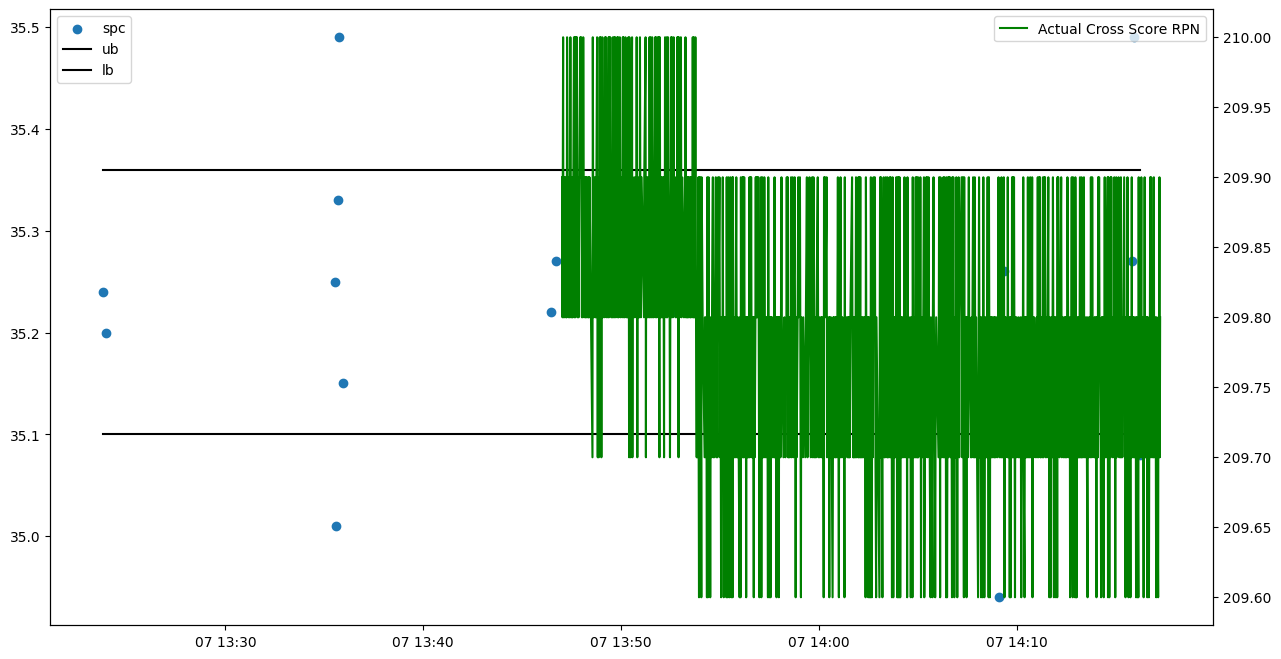

At 2024-10-07 13:53:48, CrossScore is changed from 209.9 to 209.8


In [136]:
from matplotlib import pyplot as plt

# plt.figure(figsize=(15, 8))
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
df_merge['DataTime'] = [pd.Timestamp(x) for x in df_merge['DataTime']]
ax1.scatter(df_merge['DataTime'], df_merge['Weight'], label='spc')
ax1.plot([np.min(df_merge['DataTime']), np.max(df_merge['DataTime'])], [35.36, 35.36], c='black', label='ub')
ax1.plot([np.min(df_merge['DataTime']), np.max(df_merge['DataTime'])], [35.1, 35.1], c='black', label='lb')
df_actual_cs = df_ot[df_ot['Tag']=='ActualCrossScore']
df_actual_cs['Value'] = df_actual_cs['Value'].astype(float)
ax2.plot(df_actual_cs['TS'], df_actual_cs['Value'], 'green', label='Actual Cross Score RPN')
ax1.legend()
ax2.legend()
plt.show()
if len(df_settings) == 0:
    print ('No Changes in Param Settings')
else:
    for i, row in df_settings.sort_values(by='TS', ascending=True).iterrows():
        print (f"At {row['TS']}, {row['Tag']} is changed from {row['prevValue']} to {row['Value']}")

In [133]:
df_ot[['Tag', 'TS', 'Value', 'prevValue']]

,Tag,TS,Value,prevValue
2175,ActualCrossScore,2024-10-07 13:47:01,209.9,209.8
2176,ActualCrossScore,2024-10-07 13:47:02,209.8,209.9
2177,ActualCrossScore,2024-10-07 13:47:03,209.9,209.8
2178,ActualCrossScore,2024-10-07 13:47:04,210.0,209.9
2179,ActualCrossScore,2024-10-07 13:47:05,209.8,210.0
...,...,...,...,...
528,TempUpperRealValue,2024-10-07 14:14:15,50.5,50.4
532,TempUpperRealValue,2024-10-07 14:15:15,50.6,50.5
534,TempUpperRealValue,2024-10-07 14:15:45,49.6,50.6
535,TempUpperRealValue,2024-10-07 14:16:00,50.2,49.6
